In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%cd /Midgard/home/amirme/an_explanation_model
from source.project_manager import (
    load_experiment_metadata,
    delete_experiment_data,
    check_file_exists,
)
from source.data_manager import minmax_normalize,symmetric_minmax_normalize,sum_channels
from source.labels import IMAGENET_LABELS

/Midgard/home/amirme/an_explanation_model


2023-09-01 13:46:04.094197: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-01 13:46:05.272420: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/Midgard/home/amirme/miniconda3/envs/xmodel/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
project_metadata = load_experiment_metadata(glob_path="noise_interpolation/*")
print(project_metadata.columns)
project_metadata = project_metadata.set_index(["stream_name","stream_statistic"]).sort_index()
print(project_metadata.shape)

Index(['method', 'alpha_mask_type', 'alpha_mask_value', 'projection_type',
       'projection_distribution', 'baseline_mask_type', 'baseline_mask_value',
       'write_demo', 'architecture', 'max_batches', 'min_change', 'seed',
       'batch_size', 'num_classes', 'input_shape', 'image_index',
       'monitored_statistic', 'monitored_stream', 'dataset', 'label',
       'image_path', 'time_to_compute', 'batch_index',
       'monitored_statistic_change', 'data_path', 'stream_name',
       'stream_statistic', 'csv_file_path'],
      dtype='object')
(560, 26)


In [3]:
project_metadata.index.value_counts()

stream_name              stream_statistic
alpha_mask               none                40
baseline_mask            none                40
convex_combination_mask  none                40
image                    none                40
log_probs                meanx               40
                         meanx2              40
                         none                40
projection               none                40
results_at_projection    meanx               40
                         meanx2              40
                         none                40
vanilla_grad_mask        meanx               40
                         meanx2              40
                         none                40
Name: count, dtype: int64

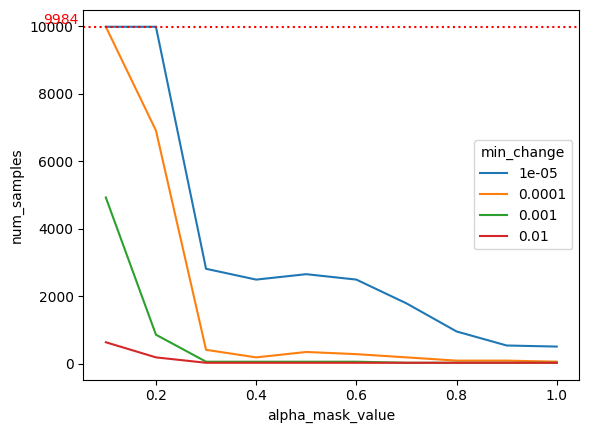

In [3]:
temp_df = project_metadata.loc[("log_probs","none"),:]
alpha_min_change_num_samples_tbl = temp_df.pivot(index="alpha_mask_value",columns="min_change",values="batch_index")
alpha_min_change_batch_size_tbl = temp_df.pivot(index="alpha_mask_value",columns="min_change",values="batch_size")
alpha_min_change_num_samples_tbl = alpha_min_change_num_samples_tbl*alpha_min_change_batch_size_tbl
alpha_min_change_num_samples_tbl.plot()
plt.ylabel("num_samples")

# max_batches
temp_row = project_metadata.iloc[0,:]
max_samples = temp_row["max_batches"] * temp_row["batch_size"]
plt.axhline(y=max_samples, color="red",linestyle=":")
plt.text(0.01,max_samples, f"{max_samples:.0f}", color="red", ha="center", va="bottom");

In [5]:
project_metadata.loc[("log_probs","none")].groupby("min_change")["time_to_compute"].agg(['sum','count'])

sum  count
min_change                   
0.00001     209.411770     10
0.00010     171.027239     10
0.00100     140.700562     10
0.01000     128.064673     10

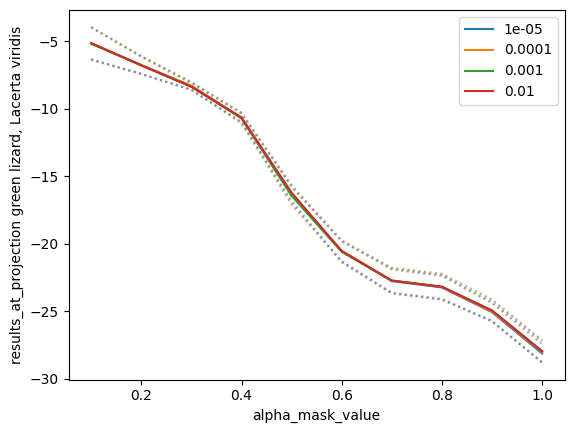

In [18]:
selected_rows = project_metadata.loc["results_at_projection",:]
selected_rows = selected_rows.set_index("alpha_mask_value",append=True).sort_index()
values = selected_rows.loc[:,"data_path"].apply(lambda path: np.load(path))
selected_rows = selected_rows.loc["meanx",:]

meanx = values.loc["meanx"]
std = np.sqrt(values.loc["meanx2"] - values.loc["meanx"]**2)
meanx.name = "meanx"
std.name = "stdx"
selected_rows = pd.concat([selected_rows,meanx,std],axis=1)
groupped = selected_rows.groupby("min_change")
groupped["meanx"].plot(legend=True)
groupped.apply(lambda x: plt.plot(
    x.index, 
    x["meanx"] - x["stdx"], 
    x.index,
    x["meanx"] + x["stdx"], 
    alpha=0.5,
    linestyle=":"))
temp_row = project_metadata.iloc[0,:]["label"]
plt.ylabel(f"results_at_projection {IMAGENET_LABELS[temp_row]}");

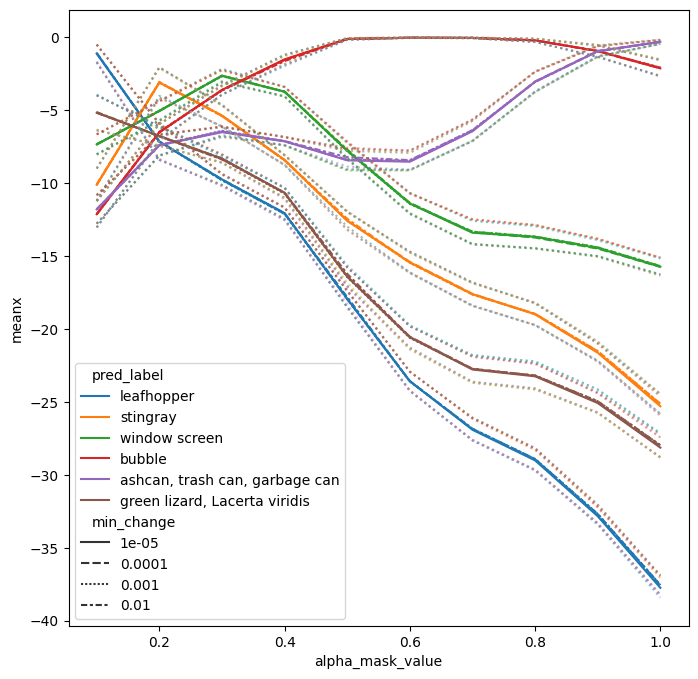

In [23]:
temp_metadata = project_metadata.set_index(["alpha_mask_value","min_change"],append=True).sort_index()
temp_metadata = temp_metadata.loc[("log_probs"),:]
values = temp_metadata.loc[:,"data_path"].apply(lambda path: np.load(path))
temp_row = project_metadata.iloc[0,:]["label"]

meanx = values.loc["meanx"]
meanx2 = values.loc["meanx2"]
meanx.name = "meanx"
stdx = (meanx2 - meanx**2).apply(lambda x: np.sqrt(x))
stdx.name = "stdx"
pred_ids = list(meanx.apply(np.argmax).unique())
pred_ids.append(temp_row)

temp_metadata = []
for pred_id in pred_ids:
    topk_meanx = meanx.apply(lambda x:x[pred_id])
    topk_stdx = stdx.apply(lambda x:x[pred_id])
    new_indexer = pd.Series(data = pred_id, index=meanx.index,name="pred_idx")
    temp_cols = pd.concat([topk_meanx,topk_stdx,new_indexer],axis=1)
    temp_metadata.append(temp_cols)

temp_metadata = pd.concat(temp_metadata)
temp_metadata["pred_label"] = temp_metadata["pred_idx"].apply(lambda x:IMAGENET_LABELS[x][:30])
temp_metadata = temp_metadata.set_index("pred_idx",append=True)

fig,ax = plt.subplots(1,1,figsize=(8,8))
sns.lineplot(ax=ax,x="alpha_mask_value", y="meanx",
             hue="pred_label", style="min_change",
             data=temp_metadata,palette="tab10")

groupped = temp_metadata.groupby(["pred_idx","min_change"])
groupped.apply(lambda x: ax.plot(
    x.index.get_level_values('alpha_mask_value'), 
    x["meanx"] - x["stdx"], 
    x.index.get_level_values('alpha_mask_value'),
    x["meanx"] + x["stdx"], 
    alpha=0.5,
    linestyle=":"));

In [5]:
def plot_masks(selector,processes=[],imshow_args={"cmap":"viridis"}):
    temp_metadata = project_metadata.set_index(["min_change","alpha_mask_value"],append=True).sort_index()
    temp_metadata = temp_metadata.loc[selector,:]
    masks = temp_metadata["data_path"].apply(lambda x:np.load(x))
    
    for process in processes:
        masks = masks.apply(process)
        
    nrows = 2
    ncols = len(masks)//nrows
    factor = 4
    fig,axes = plt.subplots(nrows,ncols,figsize=(ncols*factor,nrows*factor))
    for i,ax in enumerate(axes.flatten()):
        mask = masks.iloc[i]
        ax.imshow(mask,**imshow_args)
        ax.set_title(f"alpha={masks.index[i]:.2f} min={mask.min():.2f} max={mask.max():.2f}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

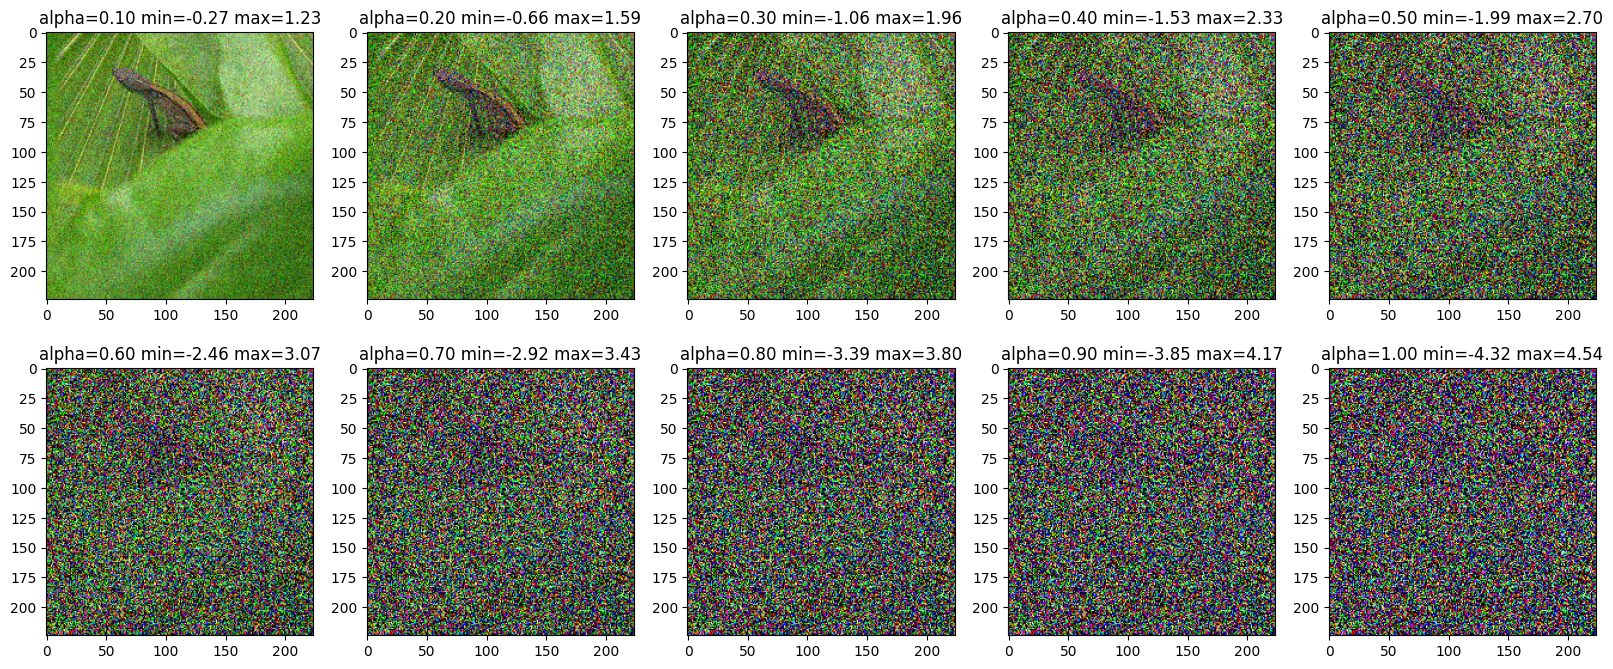

In [6]:
plot_masks(("convex_combination_mask","none",1e-5))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

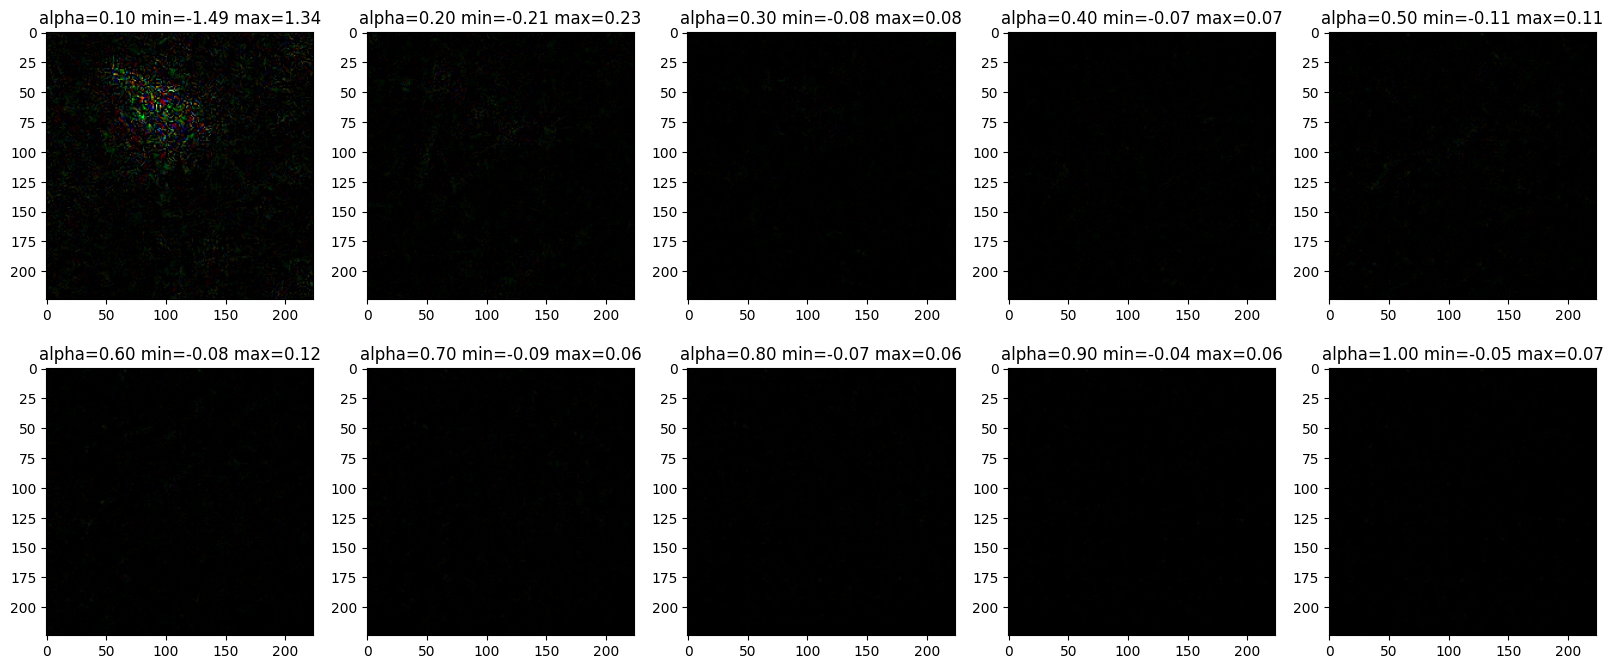

In [7]:
plot_masks(("vanilla_grad_mask","none",1e-5))

2023-09-01 13:12:41.983160: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


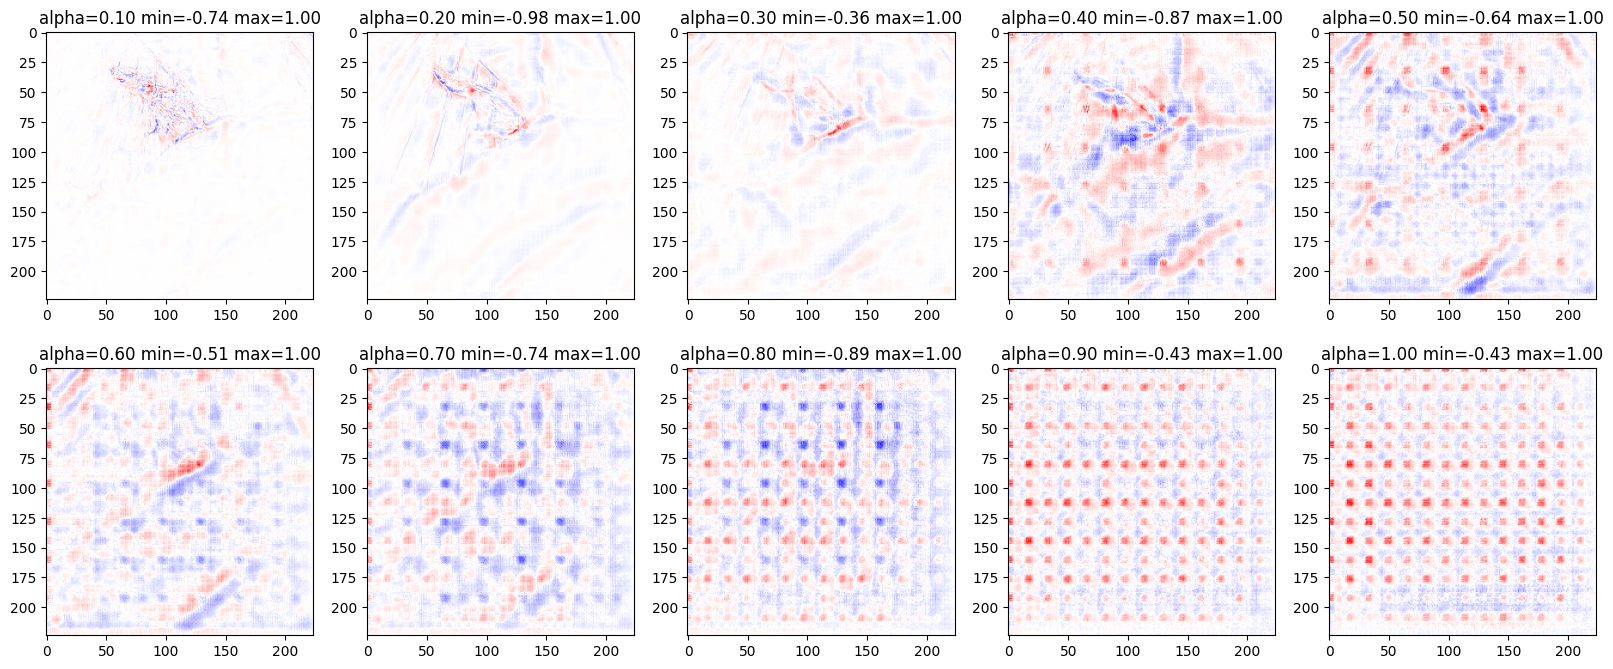

In [8]:
imshow_args = {"cmap":'bwr',"vmin":-1,"vmax":1}
plot_masks(("vanilla_grad_mask","meanx",1e-5),processes=[sum_channels,symmetric_minmax_normalize],imshow_args=imshow_args)

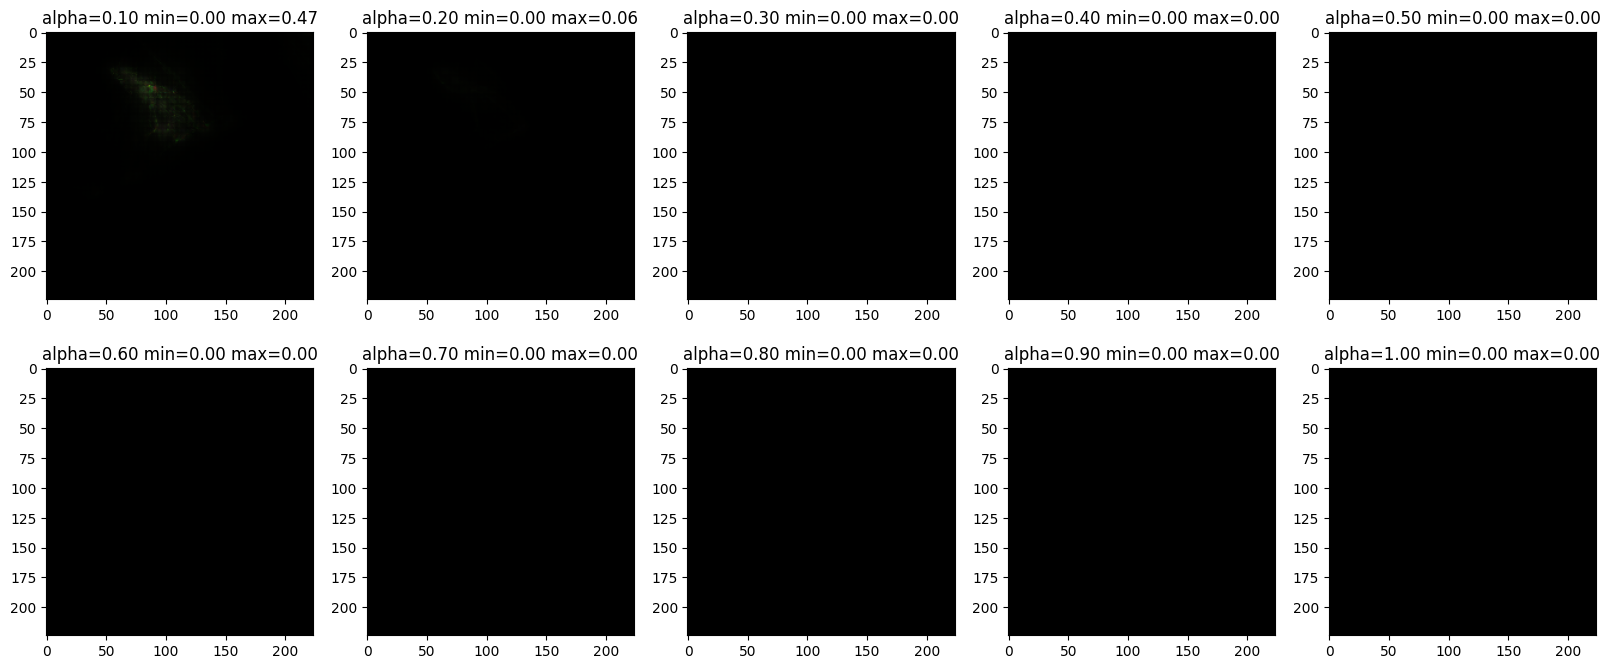

In [9]:
plot_masks(("vanilla_grad_mask","meanx2",1e-5))

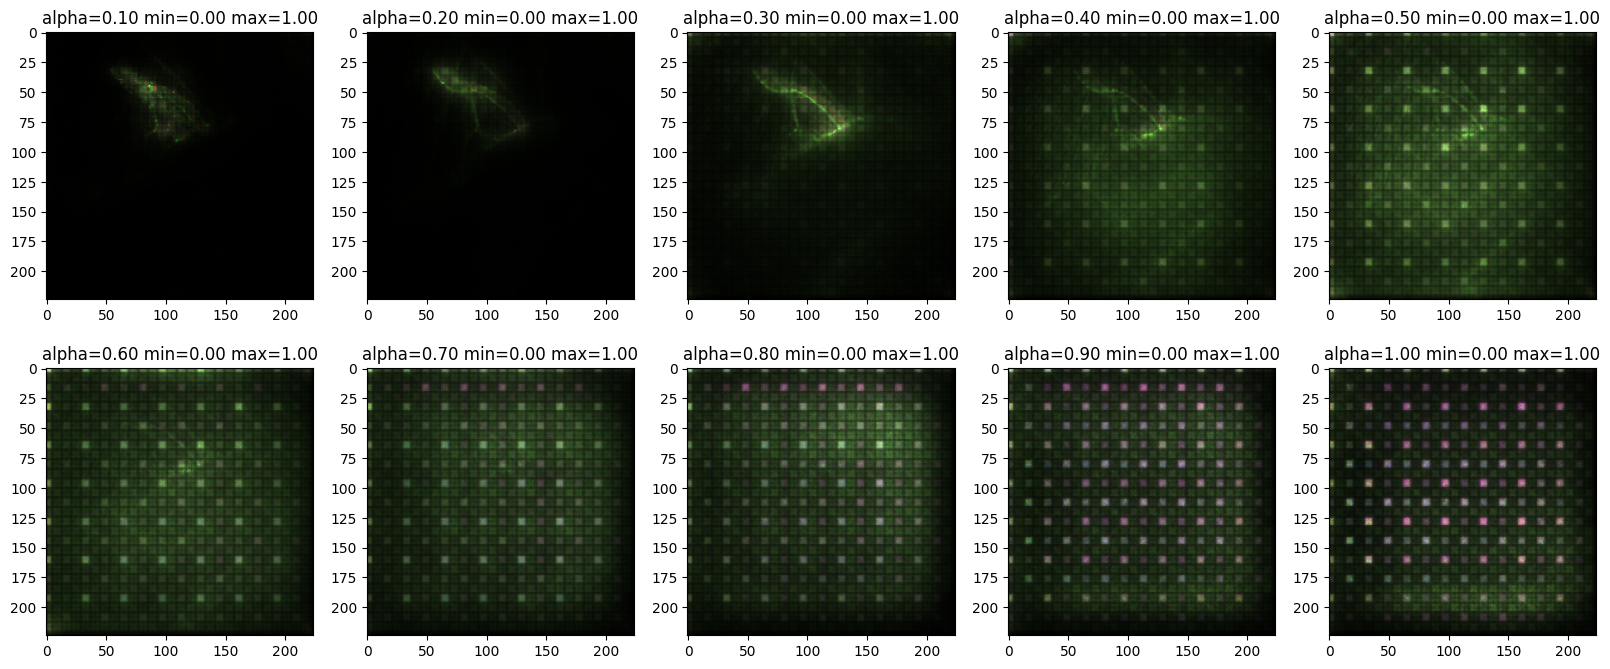

In [10]:
plot_masks(("vanilla_grad_mask","meanx2",1e-5),processes=[minmax_normalize])

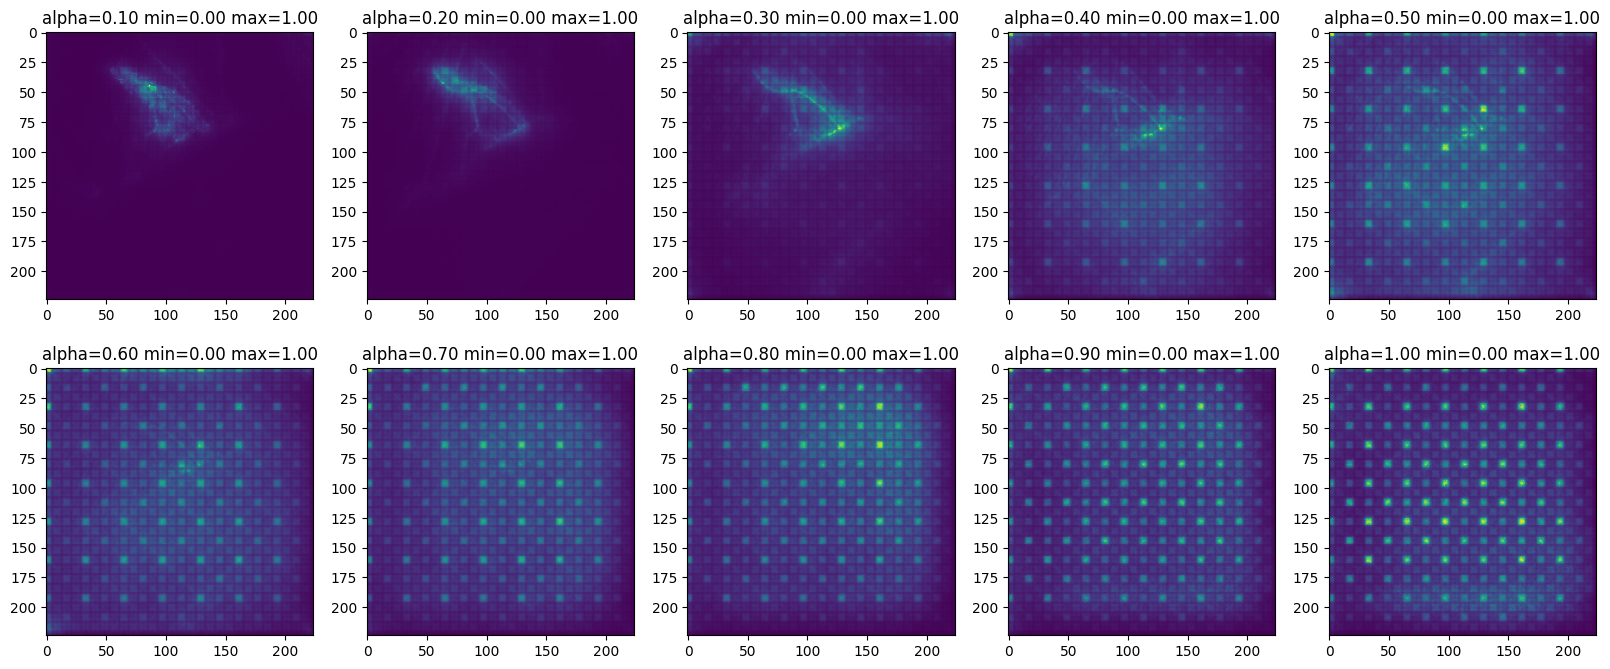

In [11]:
plot_masks(("vanilla_grad_mask","meanx2",1e-5),processes=[sum_channels,minmax_normalize])

In [ ]:
# summarize vanilla grad masks and show in one plot to compare the scales of meanx and meanx2

In [3]:
# delete_experiment_data(project_metadata["data_path"])
# check_file_exists(project_metadata["data_path"])

stream_name        stream_statistic  alpha
image              none              0.1      False
                                     0.1      False
                                     0.1      False
                                     0.1      False
                                     0.1      False
                                              ...  
vanilla_grad_mask  meanx2            1.0      False
                                     1.0      False
                                     1.0      False
                                     1.0      False
                                     1.0      False
Name: data_path, Length: 350, dtype: bool

In [13]:
# project_metadata["path_prefix"] = project_metadata["path_prefix"].apply(lambda x: f"/local_storage/users/amirme/metadata/{x}.csv")
# paths = pd.Series(project_metadata["path_prefix"].unique())
paths[0]

'/local_storage/users/amirme/metadata/2023-08-30_16-04-00-722565.csv'

In [14]:
delete_experiment_data(paths)

0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
16    None
17    None
18    None
19    None
20    None
21    None
22    None
23    None
24    None
25    None
26    None
27    None
28    None
29    None
30    None
31    None
32    None
33    None
34    None
35    None
36    None
37    None
38    None
39    None
40    None
41    None
42    None
43    None
44    None
45    None
46    None
47    None
48    None
49    None
dtype: object